In [52]:
import kagglehub
radmilasegen_dataset_path = kagglehub.dataset_download('radmilasegen/dataset-fin')

print('Data source import complete.')

Data source import complete.


In [53]:
import os
from glob import glob

BASE_PATH = "/kaggle/input/dataset-fin/new_ds"
CLASSES_PATH = os.path.join(BASE_PATH, "merged_classes.txt")

In [54]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import Dataset, DataLoader

In [55]:
IMG_SIZE = 256
EPOCHS = 10

In [56]:
def load_classes(path=CLASSES_PATH):
    with open(path, "r") as f:
        return [line.strip() for line in f.readlines() if line.strip()]

In [57]:
def read_label(label_path):
    objects = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls_id = int(parts[0])
            x, y, w, h = map(float, parts[1:])
            objects.append(
                {
                    "cls_id": cls_id,
                    "class_name": CLASSES[cls_id],
                    "x_center": x,
                    "y_center": y,
                    "width": w,
                    "height": h,
                }
            )
    return objects

In [58]:
def collect_samples(base_path=BASE_PATH):
    samples = []
    subfolders = sorted([f for f in os.listdir(base_path) if f.isdigit()])

    for folder in subfolders:
        img_dir = os.path.join(base_path, folder, "images")
        depth_dir = os.path.join(base_path, folder, "depth")
        label_dir = os.path.join(base_path, folder, "labels")

        if not (
            os.path.isdir(img_dir)
            and os.path.isdir(depth_dir)
            and os.path.isdir(label_dir)
        ):
            continue

        img_files = sorted(glob(os.path.join(img_dir, "*.png")))

        for img_path in img_files:
            fname = os.path.basename(img_path)
            depth_path = os.path.join(depth_dir, fname)
            label_path = os.path.join(label_dir, fname.replace(".png", ".txt"))

            if not os.path.exists(depth_path):
                continue
            if not os.path.exists(label_path):
                continue

            objs = read_label(label_path)
            if len(objs) == 0:
                continue

            samples.append(
                {
                    "rgb": img_path,
                    "depth": depth_path,
                    "label": label_path,
                    "objects": objs,
                }
            )
    return samples

In [59]:
def compute_depth_min_max(samples):
    d_min = float("inf")
    d_max = float("-inf")
    for s in samples:
        depth = cv2.imread(s["depth"], cv2.IMREAD_ANYDEPTH).astype(np.float32)
        if depth.size == 0:
            continue
        m = depth.min()
        M = depth.max()
        if M <= 0:
            continue
        d_min = min(d_min, m)
        d_max = max(d_max, M)

    if not np.isfinite(d_min):
        d_min = 0.0
    if not np.isfinite(d_max) or d_max <= d_min:
        d_max = d_min + 1.0
    return d_min, d_max

In [60]:
class RGBDDetectionDataset(Dataset):
    def __init__(self, samples, img_size=IMG_SIZE):
        self.samples = samples
        self.img_size = img_size

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]

        rgb = cv2.imread(item["rgb"])
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, (self.img_size, self.img_size))
        rgb = rgb.astype(np.float32)

        depth = cv2.imread(item["depth"], cv2.IMREAD_ANYDEPTH).astype(np.float32)
        depth = cv2.resize(depth, (self.img_size, self.img_size))

        d = np.clip(depth, DEPTH_MIN, DEPTH_MAX)
        d_norm = (d - DEPTH_MIN) / (DEPTH_MAX - DEPTH_MIN + 1e-6) 

        depth_ch = d_norm[..., None] 

        rgbd = np.concatenate([rgb / 255.0, depth_ch], axis=2) 
        rgbd = torch.from_numpy(rgbd).permute(2, 0, 1) 

        boxes = []
        labels = []
        for obj in item["objects"]:
            cx = obj["x_center"]
            cy = obj["y_center"]
            w = obj["width"]
            h = obj["height"]

            x1 = (cx - w / 2.0) * self.img_size
            y1 = (cy - h / 2.0) * self.img_size
            x2 = (cx + w / 2.0) * self.img_size
            y2 = (cy + h / 2.0) * self.img_size

            x1 = np.clip(x1, 0, self.img_size - 1)
            y1 = np.clip(y1, 0, self.img_size - 1)
            x2 = np.clip(x2, 0, self.img_size - 1)
            y2 = np.clip(y2, 0, self.img_size - 1)

            boxes.append([x1, y1, x2, y2])
            labels.append(obj["cls_id"] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        return rgbd, target

In [61]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

In [62]:
class ConvStem(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.stem(x) 

In [63]:
class CrossModalAttention(nn.Module):
    def __init__(self, channels=64, attn_size=8):
        super().__init__()
        self.channels = channels
        self.attn_size = attn_size

        self.pool_rgb = nn.AdaptiveAvgPool2d((attn_size, attn_size))
        self.pool_d = nn.AdaptiveAvgPool2d((attn_size, attn_size))

        self.q_rgb = nn.Conv2d(channels, channels, 1)
        self.k_d = nn.Conv2d(channels, channels, 1)
        self.v_d = nn.Conv2d(channels, channels, 1)

        self.alpha = nn.Parameter(torch.tensor(0.5))

    def forward(self, F_rgb, F_d):
        B, C, H, W = F_rgb.shape

        R = self.pool_rgb(F_rgb) 
        D = self.pool_d(F_d) 

        Q = self.q_rgb(R)
        K = self.k_d(D)
        V = self.v_d(D)

        B, C, h, w = Q.shape
        T = h * w 

        Qf = Q.view(B, C, T)
        Kf = K.view(B, C, T)
        Vf = V.view(B, C, T)

        A = torch.bmm(Qf.transpose(1, 2), Kf)
        A = torch.softmax(A, dim=-1)

        F_att_flat = torch.bmm(Vf, A.transpose(1, 2))
        F_att_small = F_att_flat.view(B, C, h, w)

        F_att = F.interpolate(F_att_small, size=(H, W), mode="bilinear", align_corners=False)

        fused = self.alpha * F_att + (1.0 - self.alpha) * F_rgb
        return fused

In [64]:
class RGBD_Backbone(nn.Module):
    def __init__(self, trainable_layers=5):
        super().__init__()

        self.rgb_stem = ConvStem(in_channels=3)
        self.depth_stem = ConvStem(in_channels=1)
        self.fusion = CrossModalAttention(channels=64, attn_size=8)
        self.body = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        self.body.conv1 = nn.Conv2d(
            64,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        layers_to_train = ["layer2", "layer3", "layer4"]
        for name, param in self.body.named_parameters():
            if not any([layer in name for layer in layers_to_train]):
                param.requires_grad = False

        self.out_channels = 256
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[ 256, 512, 1024, 2048,],
            out_channels=self.out_channels,
            extra_blocks=LastLevelMaxPool(),)
        
    def forward(self, x):
        rgb = x[:, :3, :, :]
        depth = x[:, 3:, :, :]

        F_rgb = self.rgb_stem(rgb)
        F_d = self.depth_stem(depth)
        
        F_fused = self.fusion(F_rgb, F_d)

        x = self.body.conv1(F_fused)
        x = self.body.bn1(x)
        x = self.body.relu(x)
        x = self.body.maxpool(x)

        C2 = self.body.layer1(x)
        C3 = self.body.layer2(C2)
        C4 = self.body.layer3(C3)
        C5 = self.body.layer4(C4)

        feats = self.fpn({"0": C2, "1": C3, "2": C4, "3": C5})
        return feats

In [65]:
def show_predictions(model, samples, score_thresh=0.5):
    model.eval()
    chosen = random.sample(samples, min(5, len(samples)))

    for idx, sample in enumerate(chosen):
        print(f"\ntest sample {idx+1}")

        rgb = cv2.imread(sample["rgb"])
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE))
        rgb_vis = rgb.copy()

        depth = cv2.imread(sample["depth"], cv2.IMREAD_ANYDEPTH).astype(np.float32)
        depth = cv2.resize(depth, (IMG_SIZE, IMG_SIZE))
        d = np.clip(depth, DEPTH_MIN, DEPTH_MAX)
        d_norm = (d - DEPTH_MIN) / (DEPTH_MAX - DEPTH_MIN + 1e-6)

        depth_ch = d_norm[..., None]

        rgbd = np.concatenate([rgb.astype(np.float32) / 255.0, depth_ch], axis=2)
        rgbd_t = torch.from_numpy(rgbd).permute(2, 0, 1).float().to(device)

        with torch.no_grad():
            outputs = model([rgbd_t])[0]

        boxes = outputs["boxes"].cpu().numpy()
        labels = outputs["labels"].cpu().numpy()
        scores = outputs["scores"].cpu().numpy()

        for box, label, score in zip(boxes, labels, scores):
            if score < score_thresh:
                continue
            x1, y1, x2, y2 = box.astype(int)
            cls_id = int(label) - 1
            if cls_id < 0 or cls_id >= len(CLASSES):
                continue
            cls_name = CLASSES[cls_id]

            cv2.rectangle(rgb_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(
                rgb_vis,
                f"{cls_name} {score:.2f}",
                (x1, max(0, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                1,
            )

        plt.figure(figsize=(8, 8))
        plt.title("Predictions")
        plt.imshow(rgb_vis)
        plt.axis("off")
        plt.show()

In [66]:
def box_iou(box1, box2):
    x1 = max(float(box1[0]), float(box2[0]))
    y1 = max(float(box1[1]), float(box2[1]))
    x2 = min(float(box1[2]), float(box2[2]))
    y2 = min(float(box1[3]), float(box2[3]))

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h

    if inter <= 0.0:
        return 0.0

    area1 = max(0.0, float(box1[2]) - float(box1[0])) * max(0.0, float(box1[3]) - float(box1[1]))
    area2 = max(0.0, float(box2[2]) - float(box2[0])) * max(0.0, float(box2[3]) - float(box2[1]))
    union = area1 + area2 - inter
    if union <= 0.0:
        return 0.0

    return inter / union

In [67]:
@torch.no_grad()
def evaluate_detection(model, data_loader, class_names, device=None,
                    iou_thresh=0.5, score_thresh=0.5):
    if device is None:
        device = next(model.parameters()).device

    model.eval()

    num_classes = len(class_names)

    total_gt = 0 
    total_pred = 0
    total_tp = 0 

    iou_sum = 0.0
    iou_cnt = 0

    per_class_gt = [0] * num_classes
    per_class_pred = [0] * num_classes
    per_class_tp = [0] * num_classes
    per_class_iou_sum = [0.0] * num_classes
    per_class_iou_cnt = [0] * num_classes

    for images, targets in data_loader:
        images = [img.to(device) for img in images]

        outputs = model(images)

        for out, tgt in zip(outputs, targets):
            gt_boxes = tgt["boxes"].cpu().numpy()
            gt_labels = tgt["labels"].cpu().numpy() 

            total_gt += len(gt_boxes)
            for lbl in gt_labels:
                if 1 <= lbl <= num_classes:
                    per_class_gt[lbl - 1] += 1

            if len(gt_boxes) == 0:
                pred_scores = out["scores"].cpu().numpy()
                pred_labels = out["labels"].cpu().numpy()

                keep = pred_scores >= score_thresh
                pred_labels = pred_labels[keep]

                num_pred = len(pred_labels)
                total_pred += num_pred
                for lbl in pred_labels:
                    if 1 <= lbl <= num_classes:
                        per_class_pred[lbl - 1] += 1
                continue

            pred_boxes = out["boxes"].cpu().numpy()
            pred_labels = out["labels"].cpu().numpy()
            pred_scores = out["scores"].cpu().numpy()

            keep = pred_scores >= score_thresh
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]
            pred_scores = pred_scores[keep]

            total_pred += len(pred_boxes)
            for lbl in pred_labels:
                if 1 <= lbl <= num_classes:
                    per_class_pred[lbl - 1] += 1

            matched_gt = np.zeros(len(gt_boxes), dtype=bool)

            order = np.argsort(-pred_scores)
            for p_idx in order:
                p_box = pred_boxes[p_idx]
                p_lbl = pred_labels[p_idx]
                if not (1 <= p_lbl <= num_classes):
                    continue

                best_iou = 0.0
                best_gt_idx = -1

                for g_idx, (g_box, g_lbl) in enumerate(zip(gt_boxes, gt_labels)):
                    if matched_gt[g_idx]:
                        continue
                    if g_lbl != p_lbl:
                        continue

                    iou = box_iou(p_box, g_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = g_idx

                if best_gt_idx >= 0 and best_iou >= iou_thresh:
                    matched_gt[best_gt_idx] = True
                    total_tp += 1

                    iou_sum += best_iou
                    iou_cnt += 1

                    c = p_lbl - 1
                    per_class_tp[c] += 1
                    per_class_iou_sum[c] += best_iou
                    per_class_iou_cnt[c] += 1
                else:
                    pass

    def safe_div(a, b):
        return a / b if b > 0 else 0.0

    overall_precision = safe_div(total_tp, total_pred)
    overall_recall = safe_div(total_tp, total_gt)
    overall_f1 = safe_div(2 * overall_precision * overall_recall,
                        overall_precision + overall_recall)
    overall_iou = safe_div(iou_sum, iou_cnt)

    print("Detection metrics: IoU >= {:.2f}, score >= {:.2f}".format(
        iou_thresh, score_thresh))
    print(f"  GT: {total_gt}, Pred: {total_pred}, TP: {total_tp}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall:    {overall_recall:.4f}")
    print(f"F1-score:  {overall_f1:.4f}")
    print(f"Avg IoU by TP: {overall_iou:.4f}")

    print("\nMetrics by classes:")
    for idx, name in enumerate(class_names):
        tp = per_class_tp[idx]
        gt = per_class_gt[idx]
        pred = per_class_pred[idx]
        prec = safe_div(tp, pred)
        rec = safe_div(tp, gt)
        f1 = safe_div(2 * prec * rec, prec + rec)
        avg_iou = safe_div(per_class_iou_sum[idx], per_class_iou_cnt[idx])

        print(f"[{idx+1}] {name}:")
        print(f"  GT: {gt}, Pred: {pred}, TP: {tp}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-score:  {f1:.4f}")
        print(f"  Avg IoU:   {avg_iou:.4f}")

Device: cuda
Classes: ['bottle', 'box', 'cola', 'container', 'cube', 'duck', 'pods', 'scissors', 'sphere', 'tape', 'tor']
Valid data count: 3118
Example sample: {'rgb': '/kaggle/input/dataset-fin/new_ds/1/images/00000.png', 'depth': '/kaggle/input/dataset-fin/new_ds/1/depth/00000.png', 'label': '/kaggle/input/dataset-fin/new_ds/1/labels/00000.txt', 'objects': [{'cls_id': 6, 'class_name': 'pods', 'x_center': 0.5128571428571428, 'y_center': 0.7398941798941798, 'width': 0.11523809523809515, 'height': 0.31153439153439166}]}
DEPTH_MIN, DEPTH_MAX: 0.0 65535.0
Train size: 2338 Test size: 780
Model created.
Epoch 1/3 | train_loss = 0.3570
Epoch 2/3 | train_loss = 0.2798
Epoch 3/3 | train_loss = 0.2539
Модель сохранена: rgbd_fasterrcnn_crossmodal_8x8.pth

test sample 1


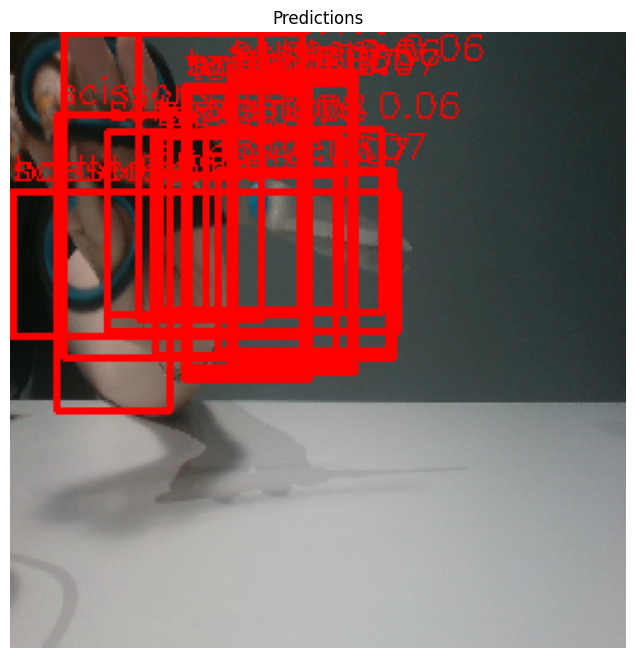


test sample 2


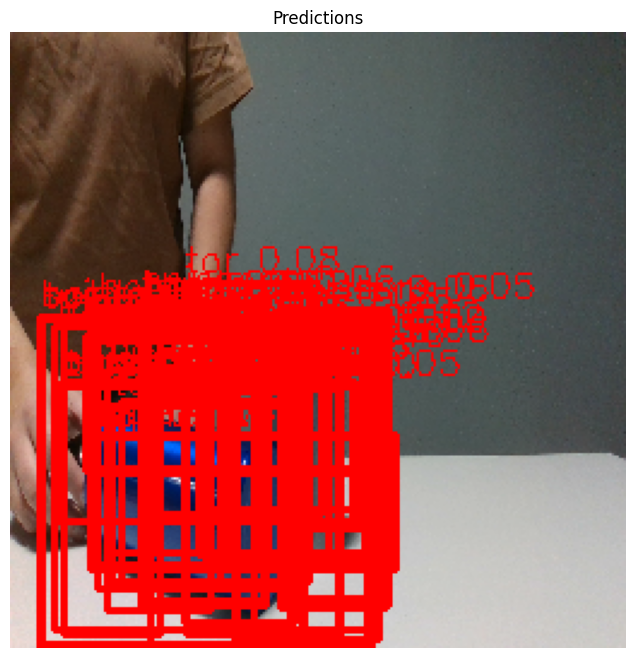


test sample 3


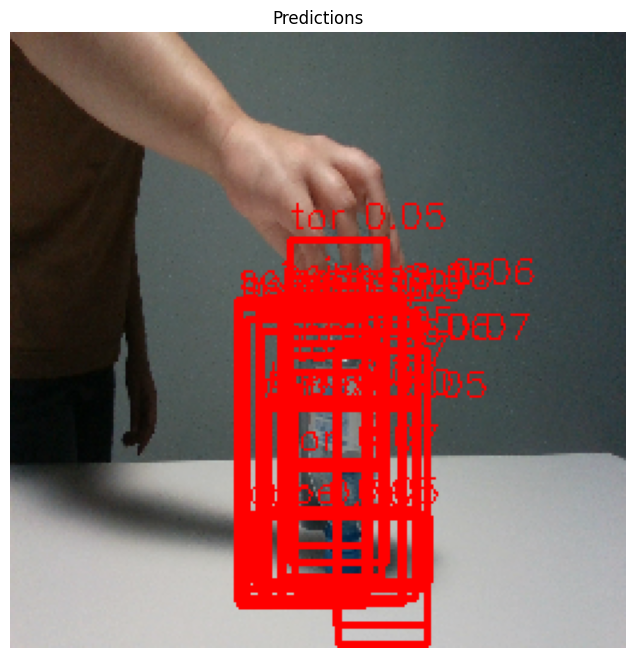


test sample 4


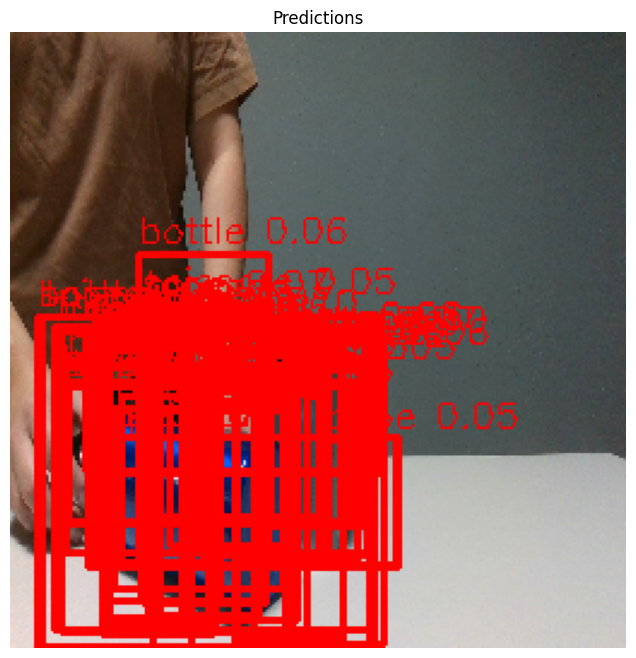


test sample 5


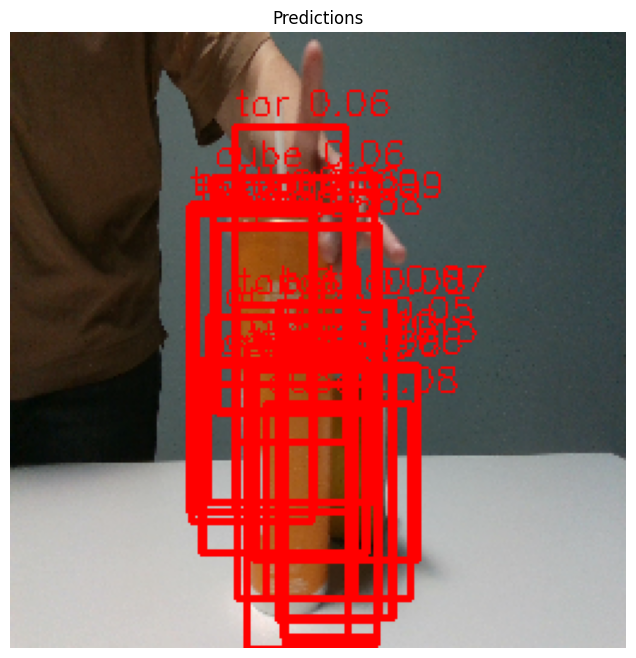

Detection metrics: IoU >= 0.05, score >= 0.05
  GT: 1807, Pred: 32061, TP: 1565
Precision: 0.0488
Recall:    0.8661
F1-score:  0.0924
Avg IoU by TP: 0.5112

Metrics by classes:
[1] bottle:
  GT: 157, Pred: 3446, TP: 141
  Precision: 0.0409
  Recall:    0.8981
  F1-score:  0.0783
  Avg IoU:   0.5016
[2] box:
  GT: 169, Pred: 1562, TP: 109
  Precision: 0.0698
  Recall:    0.6450
  F1-score:  0.1259
  Avg IoU:   0.5430
[3] cola:
  GT: 71, Pred: 415, TP: 48
  Precision: 0.1157
  Recall:    0.6761
  F1-score:  0.1975
  Avg IoU:   0.4331
[4] container:
  GT: 28, Pred: 0, TP: 0
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Avg IoU:   0.0000
[5] cube:
  GT: 215, Pred: 4605, TP: 200
  Precision: 0.0434
  Recall:    0.9302
  F1-score:  0.0830
  Avg IoU:   0.4894
[6] duck:
  GT: 160, Pred: 2551, TP: 127
  Precision: 0.0498
  Recall:    0.7937
  F1-score:  0.0937
  Avg IoU:   0.5599
[7] pods:
  GT: 50, Pred: 454, TP: 44
  Precision: 0.0969
  Recall:    0.8800
  F1-score:  0.1746
  

In [68]:
# adaption merge (Faster R-CNN + ResNet-50 FPN + Lightweight Cross-Modal Attention (8x8))

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

CLASSES = load_classes()
num_classes = len(CLASSES)
num_classes_with_bg = num_classes + 1
print("Classes:", CLASSES)

samples = collect_samples()
print("Valid data count:", len(samples))
print("Example sample:", samples[0])

DEPTH_MIN, DEPTH_MAX = compute_depth_min_max(samples)
print("DEPTH_MIN, DEPTH_MAX:", DEPTH_MIN, DEPTH_MAX)

random.shuffle(samples)
split = int(0.75 * len(samples))
train_samples = samples[:split]
test_samples = samples[split:]

train_dataset = RGBDDetectionDataset(train_samples, IMG_SIZE)
test_dataset = RGBDDetectionDataset(test_samples, IMG_SIZE)

BATCH_SIZE = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=(device == "cuda"),
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(device == "cuda"),
    collate_fn=collate_fn,
)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))

backbone = RGBD_Backbone().to(device)

anchor_generator = AnchorGenerator(
    sizes=((32,), (64,), (128,), (256,), (512,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5,
)

roi_pooler = MultiScaleRoIAlign(
    featmap_names=["0", "1", "2", "3", "pool"],
    output_size=7,
    sampling_ratio=2,
)

model = FasterRCNN(
    backbone,
    num_classes=num_classes_with_bg,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    image_mean=[0.5, 0.5, 0.5, 0.5],
    image_std=[0.25, 0.25, 0.25, 0.25],
).to(device)

print("Model created.")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.001,
    momentum=0.9,
    weight_decay=1e-4,
)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        n_batches += 1

    print(f"Epoch {epoch}/{EPOCHS} | train_loss = {total_loss / n_batches:.4f}")

torch.save(model.state_dict(), "rgbd_fasterrcnn_crossmodal_8x8.pth")
print("Модель сохранена: rgbd_fasterrcnn_crossmodal_8x8.pth")

show_predictions(model, samples, score_thresh=0.75)

evaluate_detection(model, test_loader, CLASSES, device=device, iou_thresh=0.75, score_thresh=0.75)